# Overview

Clean, analyze & graph assembly index calculations across patent data. Assemby indicies refer to the Molecular Assembly Index (MA) of a chemical compound (Marshall et al., 2021), an np-hard calculation to find the shortest theoretical construction of a molecule. All MA calculations were performed using massively parallel servers on Arizona State University's high performance cluster, SOL. The molecules analyzed here are from the chemical patent database, SureChemBL, between 1980-2022.

In [ ]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
from tqdm import tqdm
import scipy.stats as stats
from scipy.signal import find_peaks, peak_widths
import itertools
import pandas as pd
import os
import datetime as dt
from ast import literal_eval

In [ ]:
## Matplotlib setup ##
colors = {"5": "#aa0f35", 
         "6": "#fdc799",
         "7": "#a0a75c",
         "8": "#603734",
         "9": "#abdbfc",
         "10": "#313a61",
         "15": "#bfbad5",
         "20": "#f89b00",
         "full": "#313862",
         "new": "#FAB124"}

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.style.use("default")
plt.rcParams.update({'font.size': 22})

## MA Data Exploration

Read in MA results from Sol, split data into months, perform general data exploration (statistical analyses & graphs)


In [ ]:
def build_month_increments(start, stop):
    """ Build all monthly increments from the start year to stop year in the
    format YEAR-MONTH

    Args:
        start (int): start year of increments
        stop (int): end year of increments

    Returns:
        list: list of strings holding the YEAR-MONTH increments
    """
    months = []
    while start <= stop:
        for month in [
                "01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
                "11", "12"
        ]:
            months.append(str(start) + "-" + month)
        start += 1

    return months

def get_month(label):
    """ Isolates the month from the given label

    Args:
        label (str): compound id in the form YYYY-MM_label

    Returns:
        str: YYYY-MM of a particular compound
    """
    return str(label)[:7]

## Change label to match SureChemBL labels (for addition to full dataframe)
def change_label(label):
    return "SCHEMBL" + label[8:]

In [ ]:
tqdm.pandas() #For visualization

### Read in full and new dataframes (full: randomly sampled compounds, new: sampled from newly patented compounds)
fp = "Data/AssemblyValues/"
full_df = pd.read_csv(fp + "FullDatabase_AssemblyGo.csv")
new_df = pd.read_csv(fp + "NewDatabase_AssemblyGo.csv")

### Get the specific month of every compound
full_df["month"] = full_df["label"].apply(get_month)
new_df["month"] = new_df["label"].apply(get_month)

full_df = full_df.dropna()
new_df = new_df.dropna()

full_df["label"] = full_df["label"].progress_apply(change_label)
new_df["label"] = new_df["label"].progress_apply(change_label)

full_df.head()

100%|██████████| 467216/467216 [00:00<00:00, 1127715.53it/s]


,Unnamed: 0,label,MA_assemblyGo,month
0,0,SCHEMBL365031,13,1994-03
1,1,SCHEMBL370717,11,1994-09
2,2,SCHEMBL80436,22,2017-11
3,3,SCHEMBL214306,9,2010-04
4,4,SCHEMBL267327,12,2005-11


### Statistics over each month

Patents are organized by the date of filing with their respective patent agency (USPTO, EU Patent Office, etc...), so these data are organized by month to give a useful summary of time-series data.

In [7]:
full_stats = full_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})
new_stats = new_df.groupby(["month"]).agg({"MA_assemblyGo":["mean","std"]})

full_stats = full_stats.dropna(axis=0)
new_stats = new_stats.dropna(axis=0)

print(full_stats)
print("----------------------------------")
print(new_stats)


        MA_assemblyGo          
                 mean       std
month                          
1980-01     11.427544  5.496739
1980-02     11.637985  5.959078
1980-03     11.574227  5.817411
1980-04     11.903704  6.119765
1980-05     11.895228  6.340823
...               ...       ...
2019-08     17.795753  8.946237
2019-09     17.927329  9.091736
2019-10     18.435664  9.492319
2019-11     17.867147  9.534088
2019-12     16.433943  9.277880

[480 rows x 2 columns]
----------------------------------
        MA_assemblyGo          
                 mean       std
month                          
1980-01     14.143757  6.157706
1980-02     13.960581  5.858003
1980-03     13.801031  5.717696
1980-04     14.392968  6.179733
1980-05     13.453305  5.613438
...               ...       ...
2019-08     20.486815  8.461578
2019-09     20.653846  8.786538
2019-10     21.712398  9.869216
2019-11     21.838843  9.482737
2019-12     20.366935  9.087557

[480 rows x 2 columns]


### MA Over Time

Visually exploring trends for newly patented compounds and overall database over time. The major takeaway here is that MA increases linearly over time, suggesting that patents are increasing in complexity over time.

Text(0, 0.5, 'Assembly Index')

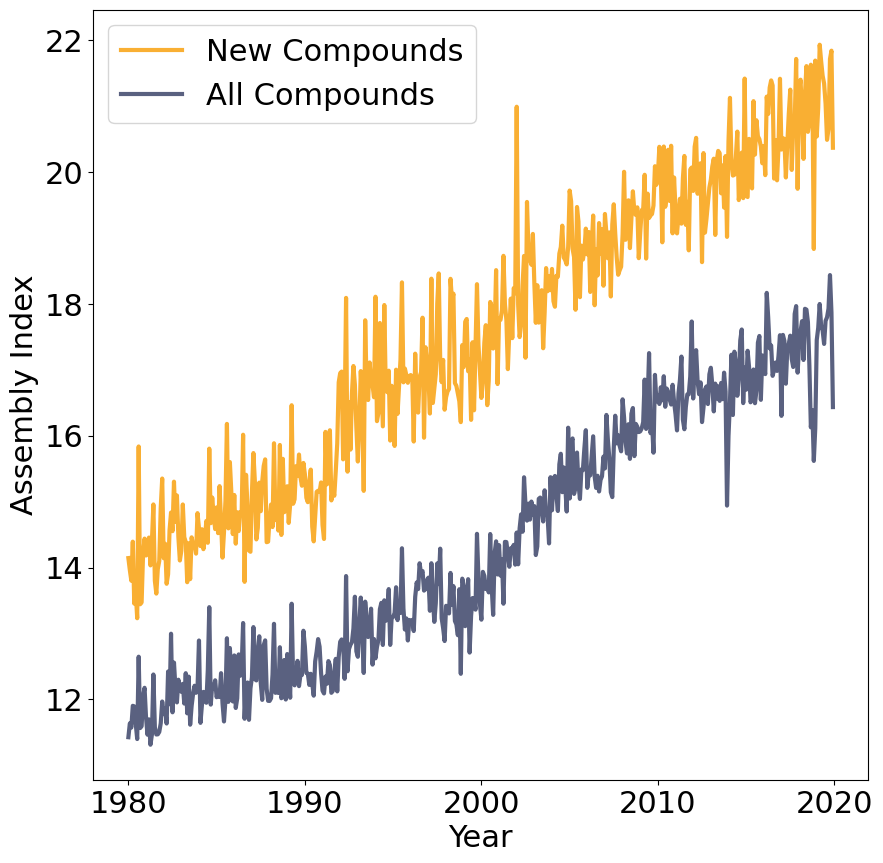

In [29]:
#Assembly values with standard deviation
plt.figure(figsize=(10,10))

plt.plot(np.arange(1980, 2020, 1/12), new_stats["MA_assemblyGo"]["mean"], color="#f89b00",
            linewidth=3, markersize=10, alpha=0.8, label="New Compounds")

plt.plot(np.arange(1980, 2020, 1/12), full_stats["MA_assemblyGo"]["mean"], color="#313a61",
            linewidth=3, markersize=10, alpha=0.8, label="All Compounds")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")

## MA Deep Analysis

After the initial observation of MA increasing over time, deep analysis aimed at:
1) MA calculations which completed in under two minutes (large molecules often did not due to algorithm)
2) Distribution of MAs across 5-year periods to observe driving forces (increases heavy-tail large numbers, something else?)

In [ ]:
MA_df_completed = pd.read_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo_COMPLETED.csv")
MA_df_completed.head()

,Unnamed: 0.1,Unnamed: 0,label,MA_assemblyGo,time,earliest_date,date_ordinal
0,3,3,SCHEMBL10000078,10.0,28.798358,2010-03-25,733856
1,4,4,SCHEMBL10000080,6.0,0.351274,2010-03-25,733856
2,12,12,SCHEMBL10000225,8.0,0.005756,2011-10-13,734423
3,13,13,SCHEMBL10000246,8.0,1.418643,2007-03-08,732743
4,14,14,SCHEMBL10000283,6.0,0.718971,2010-01-21,733793


In [8]:
def get_mean(MAs):
    try:
        return np.mean(MAs)
    except:
        return 0
    
def get_std(MAs):
    try:
        return np.std(MAs)
    except:
        return 0

def get_IQR(MAs): ### Interquartile range
    try:
        return stats.iqr(MAs, interpolation="midpoint")
    except:
        return 0

In [9]:
MA_df_months = pd.read_csv("Data/AssemblyValues/MA_df_months.csv")

MA_df_months.dropna(inplace=True)
MA_df_months["MAs"] = MA_df_months["MAs"].apply(literal_eval)

print("Calculating Means")
MA_df_months["avg"] = MA_df_months["MAs"].progress_apply(get_mean)

print("Calculating Standard Deviations")
MA_df_months["std"] = MA_df_months["MAs"].progress_apply(get_std)

print("Calculating Interquartile Ranges")
MA_df_months["iqr"] = MA_df_months["MAs"].progress_apply(get_IQR)

MA_df_months["date"] = pd.to_datetime(MA_df_months["month"])
MA_df_months["date_ordinal"] = MA_df_months["date"].map(dt.datetime.toordinal)

Calculating Means


100%|██████████| 584/584 [00:00<00:00, 6476.30it/s]


Calculating Standard Deviations


100%|██████████| 584/584 [00:00<00:00, 5479.95it/s]


Calculating Interquartile Ranges


100%|██████████| 584/584 [00:00<00:00, 2227.36it/s]


#### Distribution of MAs over time

Big question: does distribution of MAs change over time, particularly within specific time periods? This may be evidence of selection, meaning that society has generated more and more higher-range complex compounds.

(-10.0, 60.0)

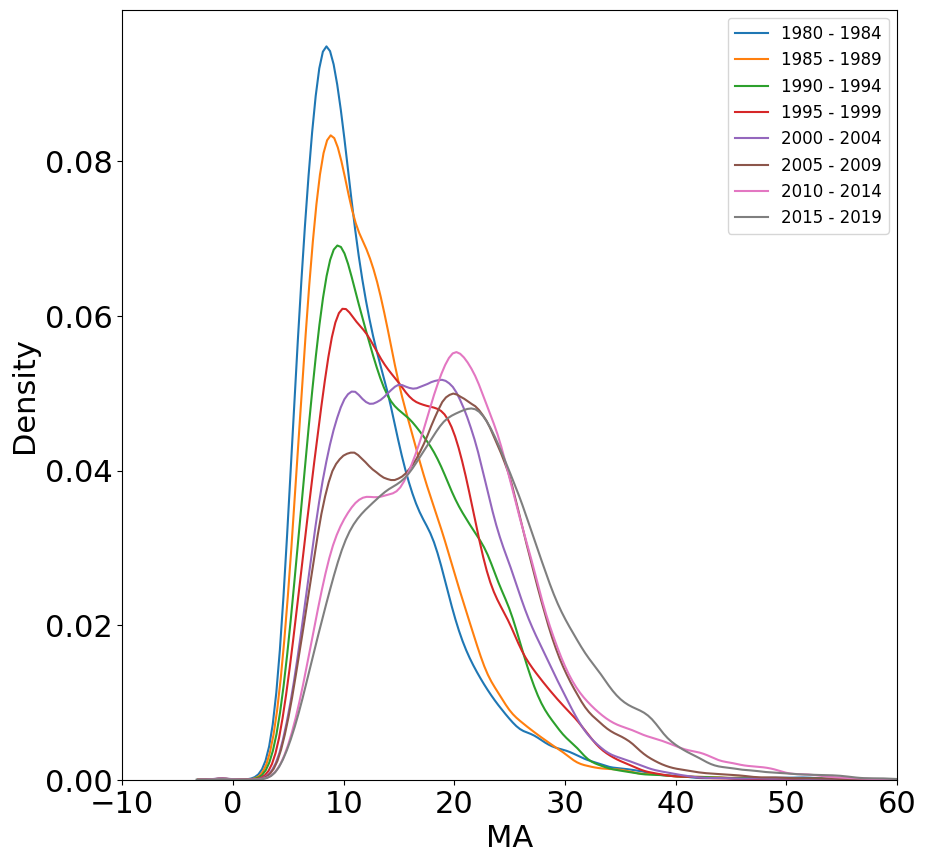

In [10]:
# sns.kdeplot(early_MAs, label = "Pre 1980")
plt.figure(figsize=(10,10))


for times in [("1980", "1984"), ("1985", "1989"), ("1990", "1994"), ("1995", "1999"), ("2000", "2004"), 
              ("2005", "2009"), ("2010", "2014"), ("2015","2019")]:
    sub_df = MA_df_months[MA_df_months["month"] > times[0]]
    sub_df = sub_df[sub_df["month"] <= times[1]]
    sub_MAs = [MA for sublist in sub_df["MAs"] for MA in sublist]

    sns.kdeplot(sub_MAs, label=str(times[0]) + " - " + str(times[1]))

plt.legend(prop={"size":12})
plt.xlabel("MA")

plt.xlim(-10, 60)

In [53]:
MA_df_months.to_csv("Data/AssemblyValues/MA_df_months.csv")

### Molecular Weight 

Graph molecular weight of molecules over time and eventually compare to MA values (hypothesis is that these values are correlated, but not 100% correlation)

In [ ]:
mw_df = pd.read_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo_MW.csv")
mw_df.head()

,Unnamed: 0,Unnamed: 0_x,Unnamed: 0.1,label,MA_assemblyGo,time,earliest_date,date_ordinal,month,Unnamed: 0_y,SureChEMBL_ID,SMILES,InChI,InChIKey,mw
0,0,0,0,SCHEMBL10,21.0,120.662484,1980-06-25,722991,1980-06,2.0,SCHEMBL10,OC(=O)C=CC(O)=O.CCOC(=O)[C@H](CCC1=CC=CC=C1)N[...,InChI=1S/C20H28N2O5.C4H4O4/c1-3-27-20(26)16(12...,OYFJQPXVCSSHAI-BDURURIASA-N,492.210781
1,1,1,1,SCHEMBL10000006,14.0,119.968879,2007-02-06,732713,2007-02,8950999.0,SCHEMBL10000006,CCN(CC)C1=CC=C(\C=C\C2=C\C(\C=C(C)O2)=C(/C#N)[...,InChI=1S/C21H21N3O/c1-5-24(6-2)19-10-7-17(8-11...,OMHICWOXVJRDPG-IGEHUKCCSA-N,331.168462
2,2,2,2,SCHEMBL10000077,19.0,119.948782,2010-03-25,733856,2010-03,8951069.0,SCHEMBL10000077,CC(=O)OCC(COC(=O)C=C)(COC(=O)C=C)COC(=O)C(F)(F...,InChI=1S/C30H34F2O16/c1-7-21(34)42-13-28(12-41...,PMUUYFUEBHMUFX-UHFFFAOYSA-N,688.181491
3,3,3,3,SCHEMBL10000078,10.0,28.798358,2010-03-25,733856,2010-03,8951070.0,SCHEMBL10000078,FC(F)(COC(=O)C=C)OC(F)(F)C(F)(F)OC(F)(F)COC(=O...,"InChI=1S/C12H10F8O6/c1-3-7(21)23-5-9(13,14)25-...",COFBONLHHZFKMO-UHFFFAOYSA-N,402.034964
4,4,4,4,SCHEMBL10000080,6.0,0.351274,2010-03-25,733856,2010-03,8951072.0,SCHEMBL10000080,FC(F)(COC(=O)C=C)COC(=O)C=C,"InChI=1S/C9H10F2O4/c1-3-7(12)14-5-9(10,11)6-15...",MAKXSYPIHRJEPP-UHFFFAOYSA-N,220.054715


In [ ]:
## Get compound labels for each month
ID_df_months = mw_df.groupby("month")["label"].apply(list).reset_index(name="IDs")
ID_df_months.to_csv("Data/ID_months.csv")

       month                                                IDs
0    1965-02                     [SCHEMBL180193, SCHEMBL180194]
1    1965-05                                      [SCHEMBL8137]
2    1965-06                                    [SCHEMBL211612]
3    1966-03                                      [SCHEMBL9114]
4    1966-07                                     [SCHEMBL37831]
..       ...                                                ...
580  2020-09  [SCHEMBL22364283, SCHEMBL22364284, SCHEMBL2237...
581  2020-10  [SCHEMBL17907879, SCHEMBL17907880, SCHEMBL1906...
582  2020-11  [SCHEMBL22617512, SCHEMBL22617513, SCHEMBL2261...
583  2020-12  [SCHEMBL11164959, SCHEMBL20847802, SCHEMBL2084...
584      NaT  [nan, SCHEMBL23141136, SCHEMBL23630220, SCHEMB...

[585 rows x 2 columns]


In [ ]:
### Group labels into molecular weights
MW_df_months = mw_df.groupby("month")["mw"].apply(list).reset_index(name="MWs")
MW_df_months.head()

       month                                                MWs
0    1965-02             [416.3290452679999, 416.3290452679999]
1    1965-05                                    [144.068748256]
2    1965-06                                    [144.068748256]
3    1966-03                                    [199.045570288]
4    1966-07                                    [117.057849224]
..       ...                                                ...
580  2020-09  [462.03967232000014, 398.05058590000016, 402.0...
581  2020-10  [228.13615912, 276.13615912, 219.104799416, 21...
582  2020-11  [239.97602608, 268.007326208, 212.131348512, 2...
583  2020-12  [240.099773612, 909.409749476, 297.08485182, 8...
584      NaT  [nan, 204.089877624, 613.769650768, 160.013638...

[585 rows x 2 columns]


In [16]:
tqdm.pandas() 

MW_df_months["avg"] = MW_df_months["MWs"].progress_apply(get_mean)
MW_df_months["std"] = MW_df_months["MWs"].progress_apply(get_std)
MW_df_months["iqr"] = MW_df_months["MWs"].progress_apply(get_IQR)

#Change dates to ordinals
MW_df_months["date"] = pd.to_datetime(MW_df_months["month"])
#MW_df_months["date_ordinal"] = MW_df_months["date"].map(dt.toordinal)

100%|██████████| 585/585 [00:00<00:00, 1785.79it/s]


Text(0, 0.5, 'Molecular Weight (Daltons)')

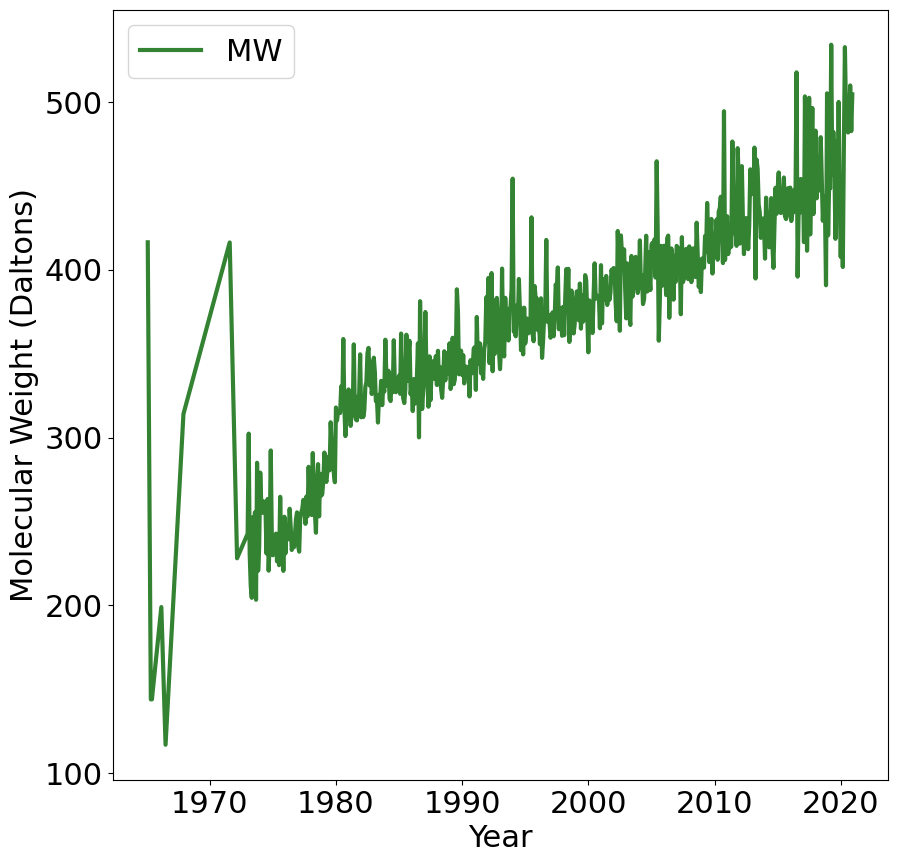

In [ ]:
#Molecular Weight over time

plt.figure(figsize=(10,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="MW")

plt.legend()
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

Text(0, 0.5, 'Molecular Weight (Daltons)')

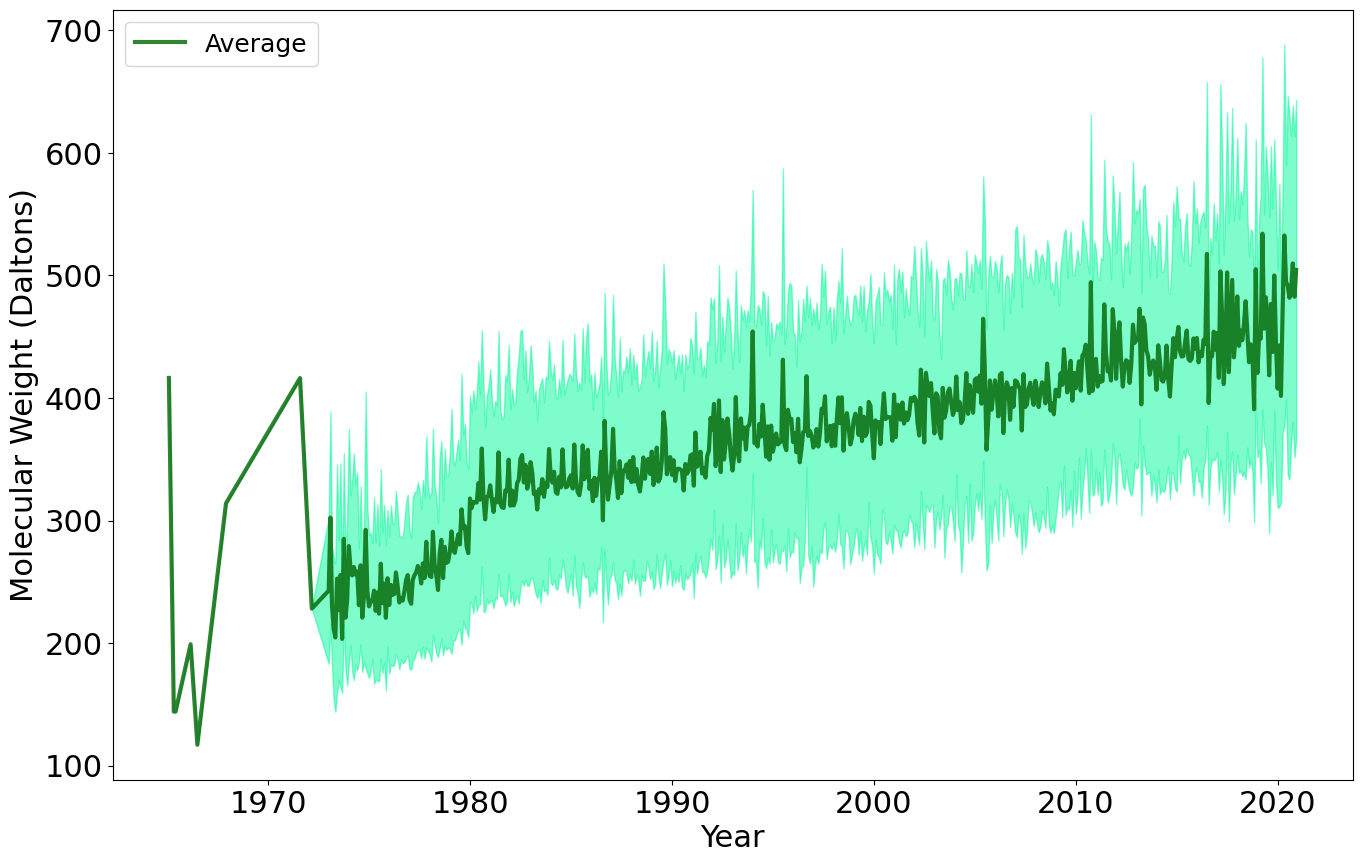

In [19]:
###MW with standard deviation

plt.figure(figsize=(16,10))

plt.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="Average")

plt.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color="mediumspringgreen",
                label="")

plt.legend(loc="upper left", prop={"size":"18"})
plt.xlabel("Year")
plt.ylabel("Molecular Weight (Daltons)")

### Combined MA/MW/(eventually) fragment figure

Text(0, 0.5, 'Molecular Weight (Daltons)')

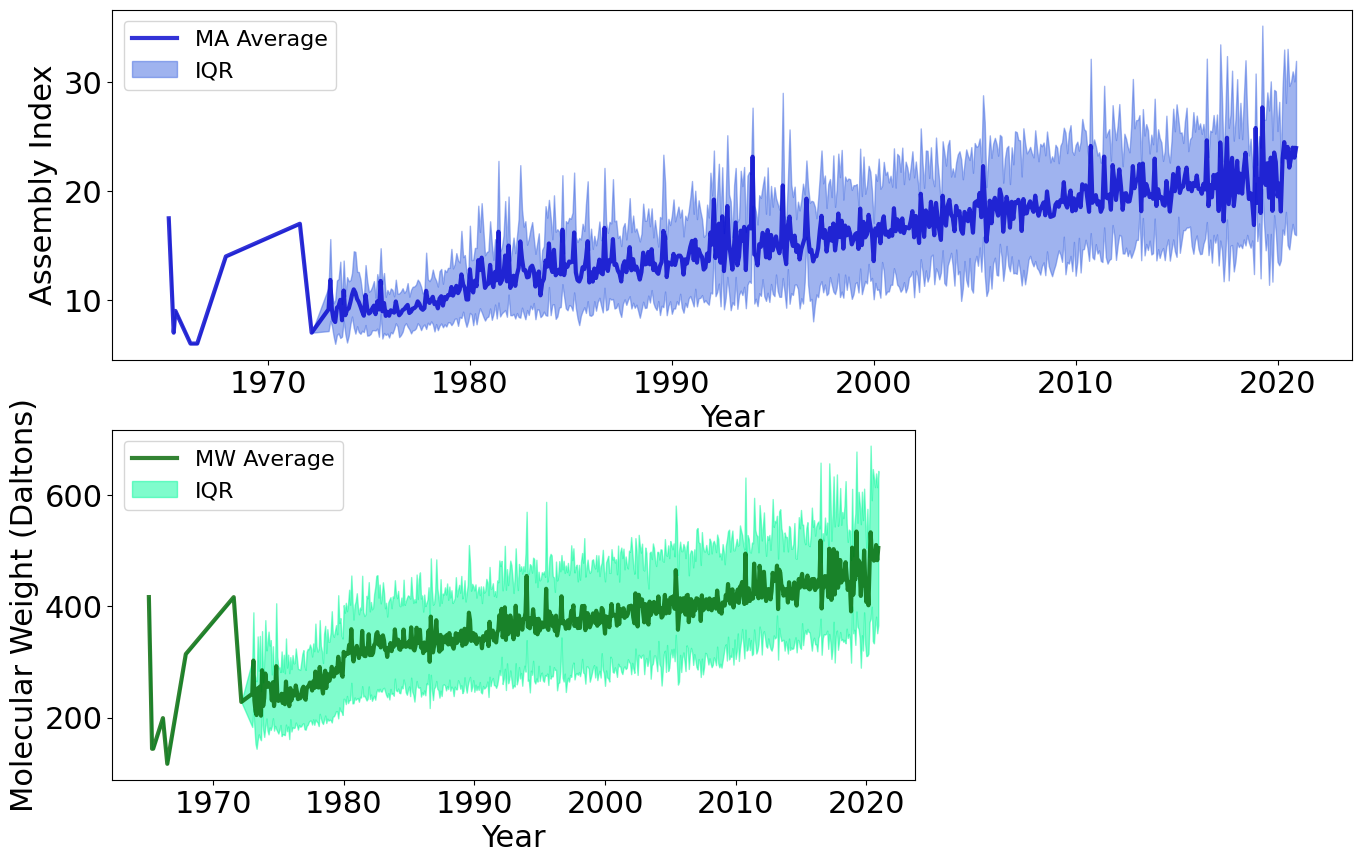

In [20]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2,3)

fig = plt.figure(figsize=(16,10))

## MA Figure
ax1 = fig.add_subplot(gs[0,:])
ax1.plot(MA_df_months["date"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

ax1.fill_between(MA_df_months["date"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color="royalblue",
                label="IQR")

ax1.legend(loc="upper left", prop={"size":"16"})
ax1.set_xlabel("Year")
ax1.set_ylabel("Assembly Index")


## MW Figure
ax2 = fig.add_subplot(gs[1,0:2])
ax2.plot(MW_df_months["date"], MW_df_months["avg"], color="darkgreen",
            linewidth=3, markersize=10, alpha=0.8, label="MW Average")

ax2.fill_between(MW_df_months["date"], MW_df_months["avg"] + MW_df_months["iqr"]/2, 
                MW_df_months["avg"] - MW_df_months["iqr"]/2, alpha=0.5, color="mediumspringgreen",
                label="IQR")

ax2.legend(loc="upper left", prop={"size":"16"})
ax2.set_xlabel("Year")
ax2.set_ylabel("Molecular Weight (Daltons)")



## Assembly/MA correlation

What is the exact correlation between the two distributions?

(0.0, 100.0)

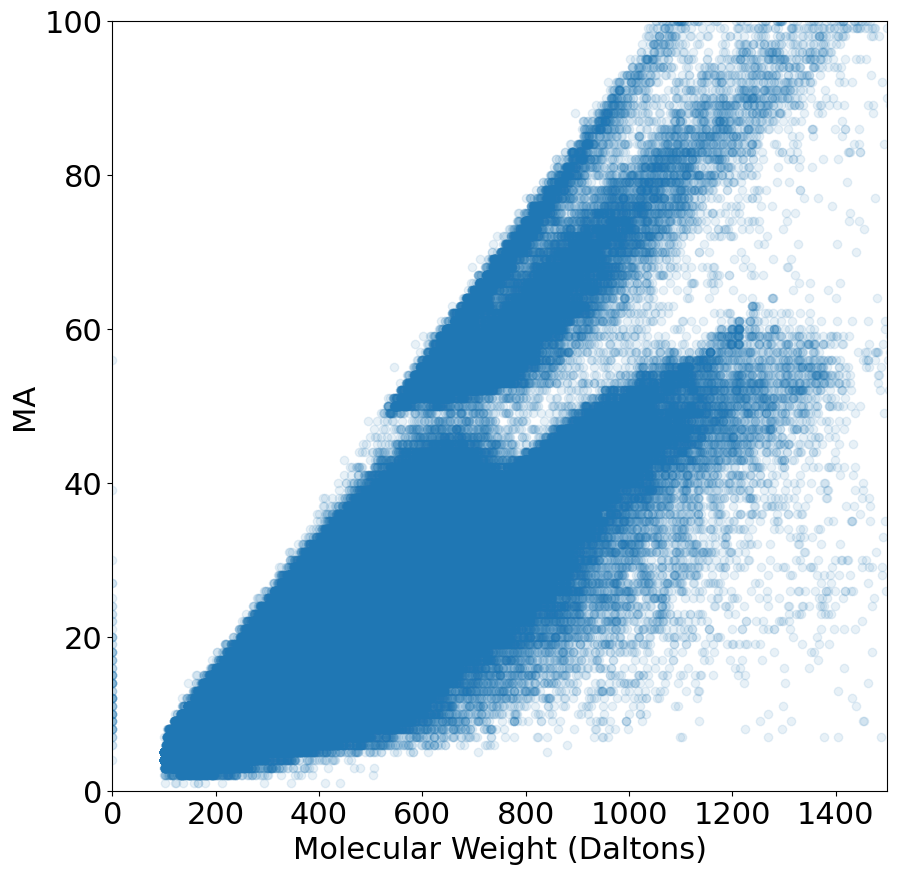

In [22]:
plt.figure(figsize=(10,10))

plt.scatter(mw_df["mw"], mw_df["MA_assemblyGo"], alpha=0.1)

plt.xlabel("Molecular Weight (Daltons)")
plt.ylabel("MA")

plt.xlim(0,1500)
plt.ylim(0,100)

In [23]:
#Basic linear regression & statistics over MA/MW distribution

mw_df_completed = mw_df.query("time < 299 and (time > 121 or time < 118)")


MA_slope, MA_intercept = np.polyfit(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"], 1)

##Calculate Spearman correlation (not assuming normality)
MA_spearman_corr = stats.spearmanr(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"])

print("Slope:", MA_slope) 
print("Intercept:", MA_intercept)
print(MA_spearman_corr)

Slope: 0.04127465523936159
Intercept: 0.4845856958174072
SignificanceResult(statistic=np.float64(0.7824007561184813), pvalue=np.float64(0.0))


(0.0, 50.0)

<Figure size 1000x1000 with 0 Axes>

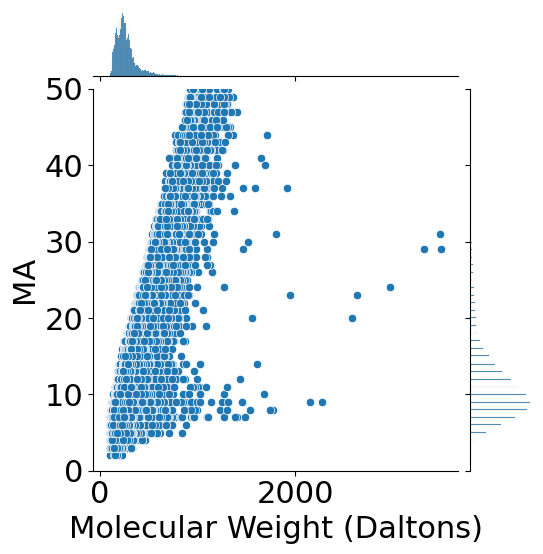

In [ ]:
plt.figure(figsize=(10,10))

sns.jointplot(x=mw_df_completed["mw"], y=mw_df_completed["MA_assemblyGo"])

plt.xlabel("Molecular Weight (Daltons)")
plt.ylabel("MA")

plt.ylim(0,50)

(0.0, 50.0)

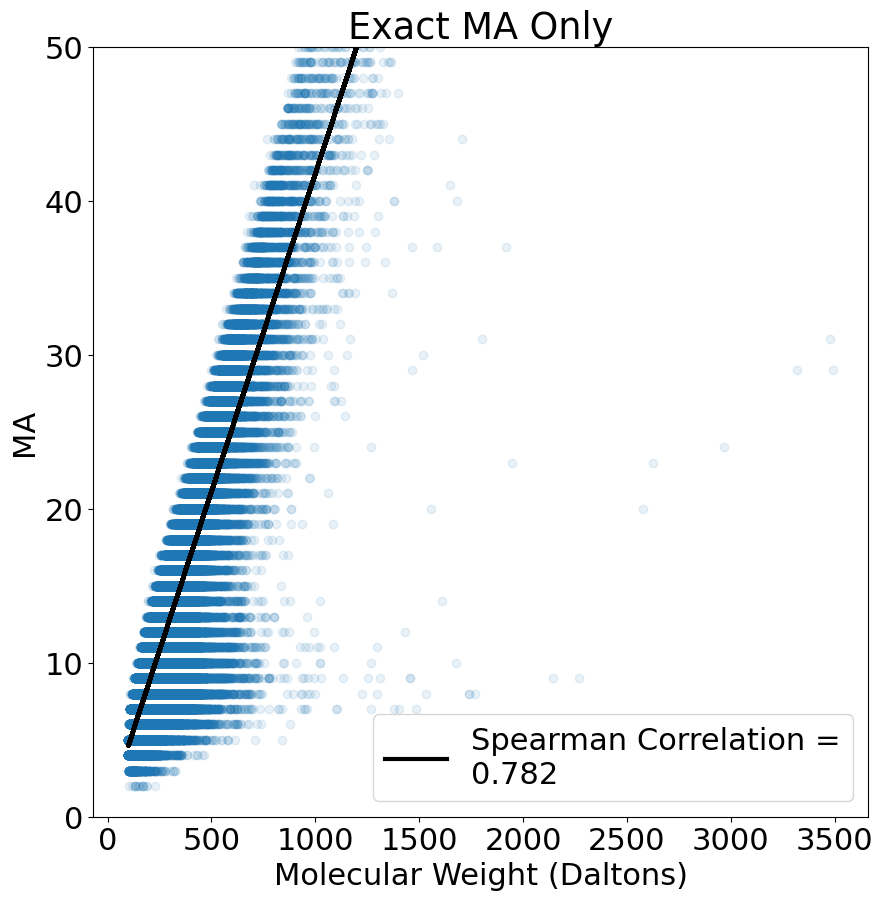

In [26]:
plt.figure(figsize=(10,10))

plt.scatter(mw_df_completed["mw"], mw_df_completed["MA_assemblyGo"], alpha=0.1)
plt.plot(mw_df_completed["mw"], MA_slope * mw_df_completed["mw"] + MA_intercept, color="k", linewidth=3,
        label="Spearman Correlation =\n" + str(round(MA_spearman_corr[0], 3)))

plt.xlabel("Molecular Weight (Daltons)")
plt.ylabel("MA")
plt.legend(loc="lower right")
plt.title("Exact MA Only")

plt.ylim(0,50)

## Time series prediction

Can we use ML to predict future MA growth?

In [ ]:
# Number of samples - starting with MA predictions
n = len(MA_df_months)

x = MA_df_months["date"].values.reshape(n, 1)
y = MA_df_months["avg"].values.reshape(n, 1)

# Train-test split (train on 70%)
prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

### AutoAIRMA for ML Time-Series Testing 

Using first test in https://towardsdatascience.com/3-unique-python-packages-for-time-series-forecasting-2926a09aaf5b

In [37]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, SimpleExponentialSmoothing

/Users/johnmalloy/opt/miniconda3/envs/chiralty_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
#Ensure proper dataframe setup (remove groupby association, change month to datetimes)
MA_df_sf = pd.DataFrame()

## Predict using 1980 onwards
MA_df_months = MA_df_months[MA_df_months["date"] >= "1980"]
MA_df_months["datetime"] = pd.to_datetime(MA_df_months["date"])
print(MA_df_months)

MW_df_sf = pd.DataFrame()

MW_df_months = MW_df_months[MW_df_months["date"] >= "1980"]
MW_df_months["datetime"] = pd.to_datetime(MW_df_months["date"])
print(MW_df_months)

     Unnamed: 0    month                                                MAs  \
92           92  1980-01  [9.0, 9.0, 7.0, 9.0, 9.0, 7.0, 6.0, 6.0, 11.0,...   
93           93  1980-02  [6.0, 9.0, 6.0, 9.0, 9.0, 8.0, 33.0, 6.0, 8.0,...   
94           94  1980-03  [16.0, 7.0, 7.0, 6.0, 10.0, 7.0, 14.0, 16.0, 1...   
95           95  1980-04  [7.0, 8.0, 13.0, 8.0, 7.0, 7.0, 9.0, 3.0, 9.0,...   
96           96  1980-05  [5.0, 9.0, 8.0, 7.0, 9.0, 7.0, 7.0, 7.0, 16.0,...   
..          ...      ...                                                ...   
579         579  2020-08  [9.0, 27.0, 24.0, 12.0, 43.0, 42.0, 44.0, 44.0...   
580         580  2020-09  [23.0, 21.0, 17.0, 17.0, 8.0, 26.0, 18.0, 12.0...   
581         581  2020-10  [10.0, 10.0, 9.0, 12.0, 19.0, 17.0, 9.0, 11.0,...   
582         582  2020-11  [11.0, 13.0, 8.0, 14.0, 12.0, 11.0, 11.0, 13.0...   
583         583  2020-12  [9.0, 46.0, 14.0, 46.0, 7.0, 47.0, 41.0, 41.0,...   

           avg      stdev   iqr       date  date_or

In [ ]:
MA_df_sf["ds"] = MA_df_months["datetime"]
MA_df_sf["y"] = MA_df_months["avg"]
MA_df_sf["unique_id"] = np.arange(0, len(MA_df_sf), 1)

MW_df_sf["ds"] = MW_df_months["datetime"]
MW_df_sf["y"] = MW_df_months["avg"]
MW_df_sf["unique_id"] = np.arange(0, len(MW_df_sf), 1)

## Set up training/test dataframes
prop_train = 0.7

n_train = round(prop_train * len(MA_df_sf))
Y_trainMA_df = MA_df_sf[:n_train]
Y_testMA_df = MA_df_sf[n_train:]

n_train = round(prop_train * len(MW_df_sf))
Y_trainMW_df = MW_df_sf[:n_train]
Y_testMW_df = MW_df_sf[n_train:]


            ds          y  unique_id
92  1980-01-01  12.818952          0
93  1980-02-01  11.160569          1
94  1980-03-01  10.691535          2
95  1980-04-01  11.780000          3
96  1980-05-01  11.270889          4
..         ...        ...        ...
579 2020-08-01  22.154389        487
580 2020-09-01  23.023863        488
581 2020-10-01  23.986946        489
582 2020-11-01  23.064516        490
583 2020-12-01  23.950999        491

[492 rows x 3 columns]
----------
            ds           y  unique_id
92  1980-01-01  317.945618          0
93  1980-02-01  310.177966          1
94  1980-03-01  315.105983          2
95  1980-04-01  314.928664          3
96  1980-05-01  314.622518          4
..         ...         ...        ...
579 2020-08-01  481.722689        487
580 2020-09-01  488.736131        488
581 2020-10-01  509.775539        489
582 2020-11-01  482.549266        490
583 2020-12-01  504.430762        491

[492 rows x 3 columns]


In [ ]:
## Set up model parameters

season_length = 1 #example is built on 12-month-long cyclical data, but this might work for me too (update: testing 1)
horizon = len(Y_testMA_df)

models = [
AutoARIMA(season_length = season_length),
AutoETS(season_length = season_length, model='ZZZ'),
SimpleExponentialSmoothing(0.99)
]

modelMA = StatsForecast(
#df=Y_testMA_df,
models=models,
freq='M',
n_jobs=-1)

modelMW = StatsForecast(
#df=Y_testMW_df,
models=models,
freq='M',
n_jobs=-1)

modelMA.fit(Y_testMA_df)
modelMW.fit(Y_testMW_df)

In [ ]:
# Addition to horizon is the number of months in the future (120 corresponds to 10 years)

Y_hatMA_df = modelMA.forecast(horizon + 120, level=[95]).reset_index()
Y_hatMA_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,AutoETS,AutoETS-lo-95,AutoETS-hi-95,SES
0,0,2020-12-31,22.249626,18.847044,25.652208,22.110113,18.484976,25.735250,23.942225
1,0,2021-01-31,22.646257,19.216087,26.076426,22.179867,18.543253,25.816481,23.942225
2,0,2021-02-28,22.646257,19.199495,26.093019,22.249620,18.601414,25.897827,23.942225
3,0,2021-03-31,22.646257,19.182981,26.109531,22.319374,18.659384,25.979364,23.942225
4,0,2021-04-30,22.646257,19.166546,26.125967,22.389128,18.717087,26.061169,23.942225


In [ ]:
Y_hatMW_df = modelMW.forecast(horizon + 120, level=[95]).reset_index()
Y_hatMW_df.head()
print(Y_hatMW_df["AutoETS"])

0      459.305298
1      460.750702
2      462.124695
3      463.430786
4      464.672394
          ...    
263    488.564331
264    488.564331
265    488.564331
266    488.564331
267    488.564331
Name: AutoETS, Length: 268, dtype: float32


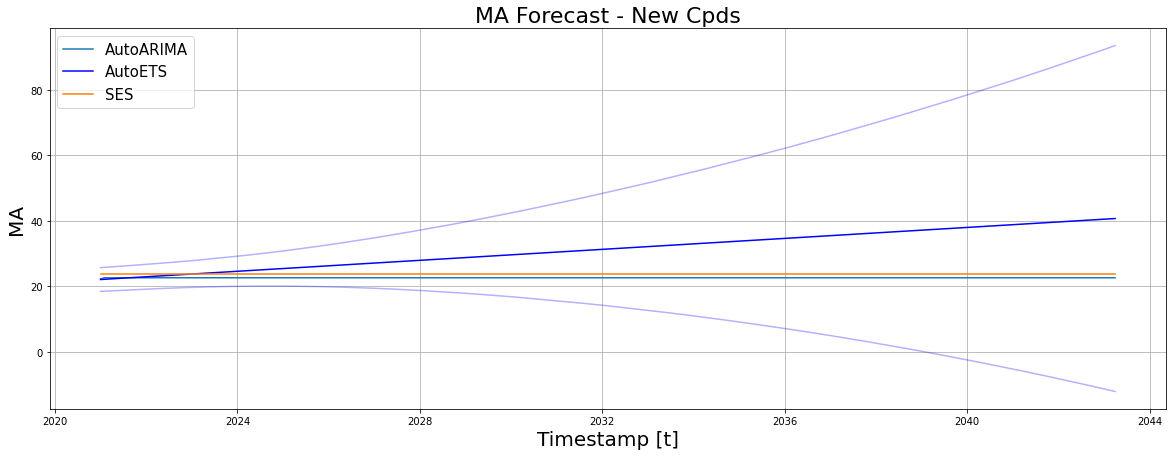

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["AutoETS-hi-95"], color="blue", alpha=0.3)
plt.plot(Y_hatMA_df["ds"], Y_hatMA_df["SES"], label="SES")

ax.set_title('MA Forecast - New Cpds', fontsize=22)
ax.set_ylabel('MA', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

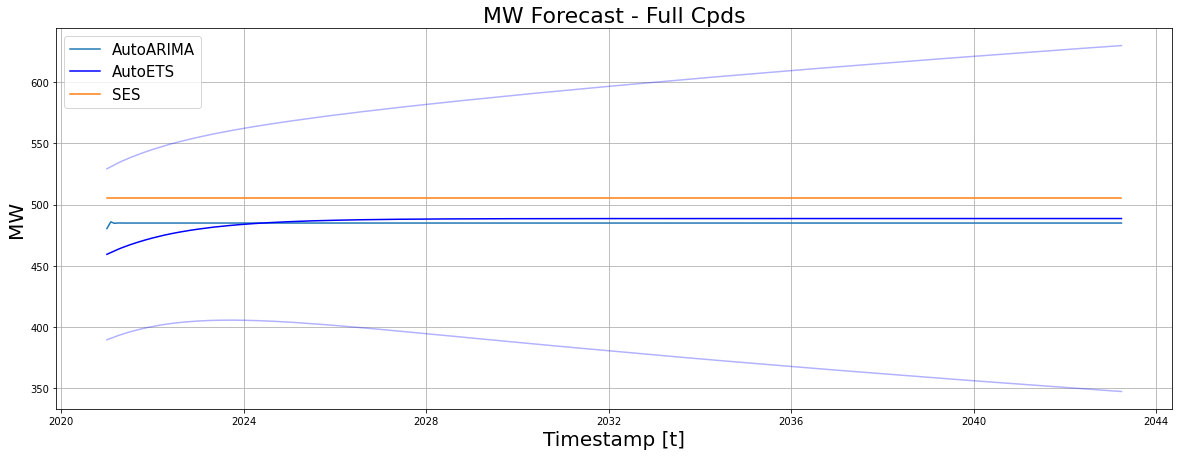

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))

plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoARIMA"], label="AutoARIMA")
plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoETS"], label="AutoETS", color="blue")
plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoETS-lo-95"], color="blue", alpha=0.3)
plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["AutoETS-hi-95"], color="blue", alpha=0.3)
plt.plot(Y_hatMW_df["ds"], Y_hatMW_df["SES"], label="SES")

ax.set_title('MW Forecast - Full Cpds', fontsize=22)
ax.set_ylabel('MW', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

Text(0, 0.5, 'Assembly Index')

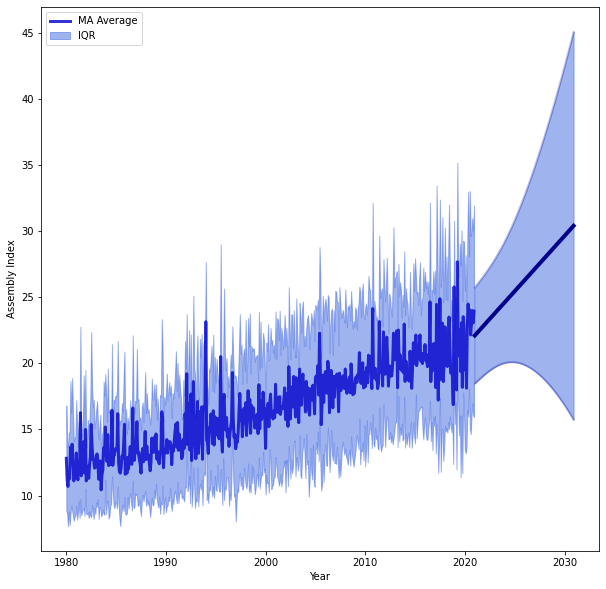

In [ ]:
#Assembly values with standard deviation & predicted values (from autoETS)
plt.figure(figsize=(10,10))

new_color = "#f89b00"
full_color= "#313a61"
xs = pd.date_range(start = "1980-01-01", end = "2020-12-01", periods = 480).to_pydatetime().tolist()


## cutoff is the prediction level (number of months in the future)
cutoff = 120

#MA cpd prediction
plt.plot(MA_df_months["datetime"], MA_df_months["avg"], color="mediumblue",
            linewidth=3, markersize=10, alpha=0.8, label="MA Average")

plt.fill_between(MA_df_months["datetime"], MA_df_months["avg"] + MA_df_months["iqr"]/2, 
                MA_df_months["avg"] - MA_df_months["iqr"]/2, alpha=0.5, color="royalblue",
                label="IQR")

plt.plot(list(Y_hatMA_df["ds"])[:cutoff], list(Y_hatMA_df["AutoETS"])[:cutoff], color="darkblue",
    linewidth=4)
plt.plot(list(Y_hatMA_df["ds"])[:cutoff], list(Y_hatMA_df["AutoETS-lo-95"])[:cutoff], color="darkblue",
    linewidth=2, alpha=0.25)
plt.plot(list(Y_hatMA_df["ds"])[:cutoff], list(Y_hatMA_df["AutoETS-hi-95"])[:cutoff], color="darkblue",
    linewidth=2, alpha=0.25)

plt.fill_between(list(Y_hatMA_df["ds"])[:120], list(Y_hatMA_df["AutoETS-lo-95"])[:120], 
    list(Y_hatMA_df["AutoETS-hi-95"])[:120], color="royalblue", alpha=0.5)


plt.legend()
plt.xlabel("Year")
plt.ylabel("Assembly Index")